In [1]:
import os
import pickle
import glob
import time

import pandas as pd
import numpy as np
import scipy.stats as stats
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import npc_lims
# from npc_sessions import DynamicRoutingSession


In [ ]:
# load_path = r'\\allen\programs\mindscope\workgroups\templeton\TTOC\average video frames and motion'
load_path={}
# load_path['face'] = r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\average video frames and motion\face'
# load_path['behavior'] = r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\average video frames and motion\behavior'
load_path['face'] = r"\\allen\programs\mindscope\workgroups\templeton\TTOC\average video frames and motion\face"
load_path['behavior'] = r"\\allen\programs\mindscope\workgroups\templeton\TTOC\average video frames and motion\behavior"

In [ ]:
#find files in path
files={}
files['face'] = glob.glob(os.path.join(load_path['face'], '*.npz'))
files['behavior'] = glob.glob(os.path.join(load_path['behavior'], '*.npz'))

angles=['behavior','face']

session_list=[]
for aa in angles:
    for ff in files[aa]:
        session_list.append(ff.split('\\')[-1][:17])

files['session_list'] = np.unique(np.asarray(session_list))

roi_x={}
roi_y={}

roi_x['behavior']=np.arange(107,227)
roi_y['behavior']=np.arange(115,190)
roi_x['face']=np.arange(236,372)
roi_y['face']=np.arange(138,272)
# #side rect
# Rect=Rectangle((107,115),227-107,190-115,linewidth=1,edgecolor='r',facecolor='none')
# #face rect
# # Rect=Rectangle((236,138),372-236,272-138,linewidth=1,edgecolor='r',facecolor='none')

In [ ]:
# session=files['session_list'][39]
# aa=angles[0]
# print(session)

# #choose file to load
# session_idx=np.where([session in ff for ff in files[aa]])[0][0]
# files[aa][session_idx]

In [ ]:
#save for each session (arrays and images)
# save_path=r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\frame_context_diffs'
# save_path=r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\frame_context_diffs'

##TODO: add diffs - within session vis diffs, aud diffs, and vis-aud but with random half of trials

all_frame_context_diffs={
    'session_id':[],
    'project':[],
    'face_frame_vis':[],
    'face_frame_aud':[],
    'face_frame_context_diff':[],
    'face_motion_vis':[],
    'face_motion_aud':[],
    'face_motion_context_diff':[],
    'behavior_frame_vis':[],
    'behavior_frame_aud':[],
    'behavior_frame_context_diff':[],
    'behavior_motion_vis':[],
    'behavior_motion_aud':[],
    'behavior_motion_context_diff':[],
    'face_frame_early':[],
    'face_frame_late':[],
    'face_frame_time_diff':[],
    'face_motion_early':[],
    'face_motion_late':[],
    'face_motion_time_diff':[],
    'behavior_frame_early':[],
    'behavior_frame_late':[],
    'behavior_frame_time_diff':[],
    'behavior_motion_early':[],
    'behavior_motion_late':[],
    'behavior_motion_time_diff':[],
    'cross_modal_dprime':[],
}

except_dict={}

#loop through sessions
for session_id in files['session_list']:
    try:
        start_time=time.time()

        # session_id=files['session_list'][39]
        session_info=npc_lims.get_session_info(session_id)
        trials=pd.read_parquet(
                    npc_lims.get_cache_path('trials',session_id,version='any')
                )
        performance=pd.read_parquet(
                    npc_lims.get_cache_path('performance',session_id,version='any')
                )
        all_frame_context_diffs['session_id'].append(session_id)
        all_frame_context_diffs['cross_modal_dprime'].append(performance['cross_modal_dprime'].mean())
        all_frame_context_diffs['project'].append(session_info.project)

        #make fake context for Templeton mice
        if 'Templeton' in session_info.project:
            start_time=trials['start_time'].iloc[0]
            fake_context=np.full(len(trials), fill_value='nan')
            fake_block_nums=np.full(len(trials), fill_value=np.nan)
            block_context_names=['vis','aud']

            if np.random.choice(block_context_names,1)=='vis':
                block_contexts=['vis','aud','vis','aud','vis','aud']
            else:
                block_contexts=['aud','vis','aud','vis','aud','vis']

            for block in range(0,6):
                block_start_time=start_time+block*10*60
                block_end_time=start_time+(block+1)*10*60
                block_trials=trials[:].query('start_time>=@block_start_time').index
                fake_context[block_trials]=block_contexts[block]
                fake_block_nums[block_trials]=block
            trials['block_index']=fake_block_nums
            trials['context_name']=fake_context

        #loop through angles
        for aa in angles:
            session_index=[]
            #load average frames/motion
            session_index=np.where([str(session_id) in ff for ff in files[aa]])[0]
            if len(session_index)==0:     
                all_frame_context_diffs[aa+'_frame_vis'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_aud'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_context_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_vis'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_aud'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_context_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_early'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_late'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_time_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_early'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_late'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_time_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                continue
            else:
                session_index=session_index[0]
            session_trial_avg=np.load(files[aa][session_index],allow_pickle=True)

            avg_prestim_frames=session_trial_avg['avg_prestim_frames']
            avg_prestim_motion=session_trial_avg['avg_prestim_motion']
            prestim_time=session_trial_avg['prestim_time']
            session_id=session_trial_avg['session_id']

            if trials.index.values[-1]>=avg_prestim_frames.shape[2]:
                all_frame_context_diffs[aa+'_frame_vis'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_aud'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_context_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_vis'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_aud'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_context_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_early'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_late'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_frame_time_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_early'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_late'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                all_frame_context_diffs[aa+'_motion_time_diff'].append(np.full((len(roi_y[aa])-1,len(roi_x[aa])-1),np.nan))
                continue

            #find context diffs for frames and motion
            vis_context_trials=trials.query('context_name=="vis"').index.values
            aud_context_trials=trials.query('context_name=="aud"').index.values
            vis_context_avg_frame=np.nanmean(avg_prestim_frames[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],vis_context_trials],axis=2)
            aud_context_avg_frame=np.nanmean(avg_prestim_frames[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],aud_context_trials],axis=2)
            vis_context_avg_motion=np.nanmean(avg_prestim_motion[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],vis_context_trials],axis=2)
            aud_context_avg_motion=np.nanmean(avg_prestim_motion[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],aud_context_trials],axis=2)

            frame_context_diff=vis_context_avg_frame-aud_context_avg_frame
            motion_context_diff=vis_context_avg_motion-aud_context_avg_motion

            #find time diffs for frames and motion
            early_trials=trials.query('block_index<3').index.values
            late_trials=trials.query('block_index>=3').index.values
            early_avg_frame=np.nanmean(avg_prestim_frames[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],early_trials],axis=2)
            late_avg_frame=np.nanmean(avg_prestim_frames[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],late_trials],axis=2)
            early_avg_motion=np.nanmean(avg_prestim_motion[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],early_trials],axis=2)
            late_avg_motion=np.nanmean(avg_prestim_motion[roi_y[aa][0]:roi_y[aa][-1],roi_x[aa][0]:roi_x[aa][-1],late_trials],axis=2)

            frame_time_diff=early_avg_frame-late_avg_frame
            motion_time_diff=early_avg_motion-late_avg_motion

            all_frame_context_diffs[aa+'_frame_vis'].append(vis_context_avg_frame)
            all_frame_context_diffs[aa+'_frame_aud'].append(aud_context_avg_frame)
            all_frame_context_diffs[aa+'_frame_context_diff'].append(frame_context_diff)
            all_frame_context_diffs[aa+'_motion_vis'].append(vis_context_avg_motion)
            all_frame_context_diffs[aa+'_motion_aud'].append(aud_context_avg_motion)
            all_frame_context_diffs[aa+'_motion_context_diff'].append(motion_context_diff)
            all_frame_context_diffs[aa+'_frame_early'].append(early_avg_frame)
            all_frame_context_diffs[aa+'_frame_late'].append(late_avg_frame)
            all_frame_context_diffs[aa+'_frame_time_diff'].append(frame_time_diff)
            all_frame_context_diffs[aa+'_motion_early'].append(early_avg_motion)
            all_frame_context_diffs[aa+'_motion_late'].append(late_avg_motion)
            all_frame_context_diffs[aa+'_motion_time_diff'].append(motion_time_diff)

        elapsed_time=time.time()-start_time
        print(session_id,'done in',np.round(elapsed_time,decimals=1),'seconds')
    except Exception as e:
        except_dict[session_id]=e
        print(session_id,'failed:',e)


In [ ]:
# avg_prestim_frames.shape
(len(roi_y[aa]),roi_x[aa])

In [ ]:
# trials['block_index']
all_frame_context_diffs=pd.DataFrame(all_frame_context_diffs)

In [ ]:
# savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\frame context diffs\all_frame_context_diffs.pkl"
savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\frame context diffs\all_frame_context_diffs_templ.pkl"
all_frame_context_diffs.to_pickle(savepath)

In [2]:
DR_frame_context_diffs=pd.read_pickle(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\frame context diffs\all_frame_context_diffs.pkl")
Templ_frame_context_diffs=pd.read_pickle(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\frame context diffs\all_frame_context_diffs_templ.pkl")

all_frame_context_diffs=pd.concat([DR_frame_context_diffs,Templ_frame_context_diffs],axis=0)

In [ ]:
Templ_frame_context_diffs.iloc[0:3]

In [13]:
all_frame_context_diffs.iloc[0:3]

,session_id,project,face_frame_vis,face_frame_aud,face_frame_context_diff,face_motion_vis,face_motion_aud,face_motion_context_diff,behavior_frame_vis,behavior_frame_aud,...,face_motion_early,face_motion_late,face_motion_time_diff,behavior_frame_early,behavior_frame_late,behavior_frame_time_diff,behavior_motion_early,behavior_motion_late,behavior_motion_time_diff,cross_modal_dprime
0,626791_2022-08-15,DynamicRouting,"[[7.203846153846154, 7.096153846153846, 6.7807...","[[7.146118721461187, 6.863013698630137, 6.4977...","[[0.057727432384966804, 0.23314014752370849, 0...","[[0.03461538461538462, 0.03076923076923077, 0....","[[0.0273972602739726, 0.0182648401826484, 0.00...","[[0.007218124341412016, 0.01250439058658237, 0...","[[3.996153846153846, 3.9, 4.042307692307692, 4...","[[3.721461187214612, 3.712328767123288, 3.7808...",...,"[[0.02040816326530612, 0.0163265306122449, 0.0...","[[0.042735042735042736, 0.03418803418803419, 0...","[[-0.022326879469736615, -0.017861503575789292...","[[4.0, 3.8938775510204082, 4.053061224489796, ...","[[3.735042735042735, 3.730769230769231, 3.7863...","[[0.2649572649572649, 0.16310832025117739, 0.2...","[[0.11428571428571428, 0.09387755102040816, 0....","[[0.12393162393162394, 0.08974358974358974, 0....","[[-0.009645909645909653, 0.004133961276818421,...",1.704476
1,626791_2022-08-16,DynamicRouting,"[[6.72972972972973, 7.0, 7.1312741312741315, 7...","[[6.676348547717843, 6.8838174273858925, 6.975...","[[0.05338118201188724, 0.11618257261410747, 0....","[[0.11583011583011583, 0.14285714285714285, 0....","[[0.07883817427385892, 0.07053941908713693, 0....","[[0.036991941556256916, 0.07231772377000592, 0...","[[3.722007722007722, 3.6911196911196913, 3.725...","[[3.672199170124481, 3.6182572614107884, 3.593...",...,"[[0.05426356589147287, 0.03488372093023256, 0....","[[0.1446280991735537, 0.1859504132231405, 0.14...","[[-0.09036453328208084, -0.15106669229290792, ...","[[3.9147286821705425, 3.872093023255814, 3.829...","[[3.4669421487603307, 3.425619834710744, 3.483...","[[0.4477865334102118, 0.44647318854507034, 0.3...","[[0.3449612403100775, 0.3643410852713178, 0.36...","[[0.32231404958677684, 0.26859504132231404, 0....","[[0.02264719072330068, 0.09574604394900377, 0....",1.271511
2,626791_2022-08-17,DynamicRouting,"[[4.673076923076923, 5.042307692307692, 5.4653...","[[4.936507936507937, 4.984126984126984, 5.1230...","[[-0.2634310134310134, 0.058180708180707974, 0...","[[0.05, 0.05, 0.04230769230769231, 0.034615384...","[[0.03571428571428571, 0.027777777777777776, 0...","[[0.01428571428571429, 0.022222222222222227, 0...","[[3.8038461538461537, 3.8038461538461537, 3.91...","[[3.7817460317460316, 3.7936507936507935, 3.92...",...,"[[0.038314176245210725, 0.034482758620689655, ...","[[0.04780876494023904, 0.043824701195219126, 0...","[[-0.009494588695028318, -0.009341942574529472...","[[3.8084291187739465, 3.796934865900383, 3.885...","[[3.7768924302788847, 3.800796812749004, 3.956...","[[0.03153668849506186, -0.0038619468486209563,...","[[0.1417624521072797, 0.09961685823754789, 0.0...","[[0.13147410358565736, 0.11155378486055777, 0....","[[0.010288348521622331, -0.01193692662300988, ...",1.031870


In [ ]:
#example images
sel_session=8

vis_col_name='behavior_frame_vis'
vis_image=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[vis_col_name].iloc[sel_session]

aud_col_name='behavior_frame_aud'
aud_image=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[aud_col_name].iloc[sel_session]

maxval=np.nanmax(np.abs(vis_image))
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(vis_image,vmin=0,vmax=maxval,cmap='grey')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(vis_col_name.replace('_',' '))

ax[1].imshow(aud_image,vmin=0,vmax=maxval,cmap='grey')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(aud_col_name.replace('_',' '))


In [ ]:
#example images
sel_session=8

session_id=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')['session_id'].iloc[sel_session]

vis_col_name='behavior_motion_vis'
vis_image=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[vis_col_name].iloc[sel_session]

aud_col_name='behavior_motion_aud'
aud_image=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[aud_col_name].iloc[sel_session]

diff_col_name='behavior_motion_context_diff'
diff_image=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[diff_col_name].iloc[sel_session]

maxval=np.nanmax(np.abs(vis_image))
diff_maxval=np.nanmax(np.abs(diff_image))

fig,ax=plt.subplots()
ax.imshow(vis_image,vmin=0,vmax=maxval,cmap='grey')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(session_id+' '+vis_col_name.replace('_',' '))

fig,ax=plt.subplots()
ax.imshow(aud_image,vmin=0,vmax=maxval,cmap='grey')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(session_id+' '+aud_col_name.replace('_',' '))

fig,ax=plt.subplots()
ax.imshow(diff_image,vmin=-diff_maxval,vmax=diff_maxval,cmap='bwr')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(session_id+' '+diff_col_name.replace('_',' '))


Text(0.5, 0.98, 'behavior motion context diff')

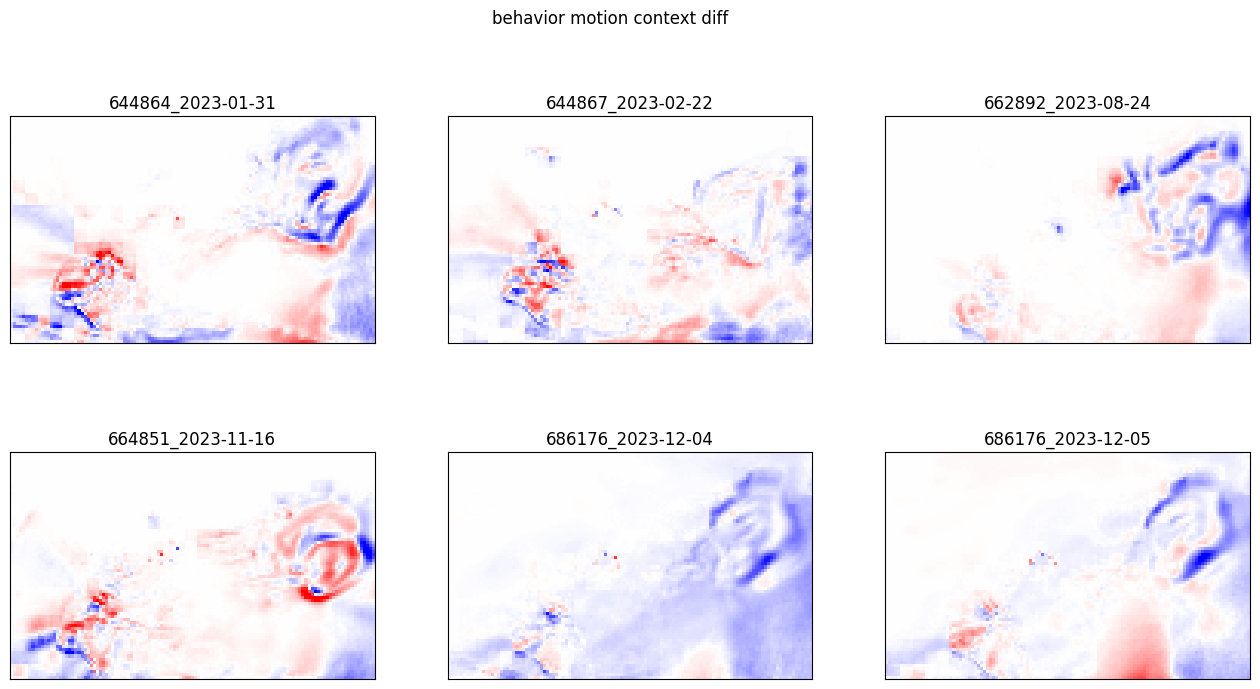

In [25]:
#display multiple images

sel_sessions=[8,16,26,30,45,46]

col_name='behavior_motion_context_diff'

fig,ax=plt.subplots(2,3,figsize=(16,8))
ax=ax.flatten()

for si,ss in enumerate(sel_sessions):
    session_id=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')['session_id'].iloc[ss]
    image=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[col_name].iloc[ss]
    # ax[si].imshow(image,cmap='grey')
    # ax[si].imshow(image,vmin=-25,vmax=25,cmap='bwr')
    ax[si].imshow(image,vmin=-6,vmax=6,cmap='bwr')
    ax[si].set_xticks([])
    ax[si].set_yticks([])
    ax[si].set_title(session_id)

fig.suptitle(col_name.replace('_',' '))


In [ ]:
col_name='behavior_motion_context_diff'
image=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[col_name].values.mean()
maxval=np.nanmax(np.abs(image))
fig,ax=plt.subplots()
ax.imshow(image,vmin=-maxval,vmax=maxval,cmap='bwr')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(col_name.replace('_',' ')+' (max value='+str(np.round(maxval,decimals=2))+')')


In [ ]:
col_name0='face_frame_context_diff'
col_name1='face_frame_time_diff'
image0=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[col_name0].mean(skipna=True)
image1=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1')[col_name1].mean(skipna=True)
dr_n=all_frame_context_diffs.query('project=="DynamicRouting" and cross_modal_dprime>=1').shape[0]

col_name2='face_frame_context_diff'
col_name3='face_frame_time_diff'
image2=all_frame_context_diffs.query('project.str.contains("Templeton") and ~session_id.str.contains("646318_2023-01-18")')[col_name2].values
image2=np.nanmean(np.stack(image2,axis=2),axis=2)
image3=all_frame_context_diffs.query('project.str.contains("Templeton") and ~session_id.str.contains("646318_2023-01-18")')[col_name3].values
image3=np.nanmean(np.stack(image3,axis=2),axis=2)
templ_n=all_frame_context_diffs.query('project.str.contains("Templeton") and ~session_id.str.contains("646318_2023-01-18")').shape[0]

maxval=np.nanmax(np.abs(image0))
fig,ax=plt.subplots(2,2,figsize=(10,7))
ax[0,0].imshow(image0,vmin=-maxval,vmax=maxval,cmap='bwr')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('DR '+col_name0.replace('_',' ')+' (n='+str(dr_n)+')') #+' (max value='+str(np.round(maxval,decimals=2))+')')

ax[1,0].imshow(image1,vmin=-maxval,vmax=maxval,cmap='bwr')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title('DR '+col_name1.replace('_',' '))

ax[0,1].imshow(image2,vmin=-maxval,vmax=maxval,cmap='bwr')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('Templeton '+col_name2.replace('_',' ')+' (n='+str(templ_n)+')')

ax[1,1].imshow(image3,vmin=-maxval,vmax=maxval,cmap='bwr')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title('Templeton '+col_name3.replace('_',' '))


fig.tight_layout()
#make colorbar
cax=fig.add_axes([1.01,0.05,0.02,0.9])
fig.colorbar(ax[0,0].imshow(image0,vmin=-maxval,vmax=maxval,cmap='bwr'),cax=cax)
cax.set_ylabel('pixel difference value')



In [ ]:
templ_sessions=all_frame_context_diffs.query('project.str.contains("Templeton") and ~session_id.str.contains("646318_2023-01-18")')

for ss,session in templ_sessions.iterrows():
    image=session['behavior_frame_time_diff']
    session_id=session['session_id']
    maxval=np.nanmax(np.abs(image))
    fig,ax=plt.subplots(1,1)
    ax.imshow(image,vmin=-maxval,vmax=maxval,cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(session_id+' (max value='+str(np.round(maxval,decimals=2))+')')



In [ ]:
# for ff in all_frame_context_diffs['behavior_frame_context_diff']:
#     print(ff.shape)

In [ ]:
col_name='behavior_frame_context_diff'
image=np.nanmean(np.stack(all_frame_context_diffs.query('project.str.contains("Templeton")')[col_name].values,axis=2),axis=2)
maxval=np.nanmax(np.abs(image))
# maxval=10
fig,ax=plt.subplots()
ax.imshow(image,vmin=-maxval,vmax=maxval,cmap='bwr')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(col_name.replace('_',' ')+' (max value='+str(np.round(maxval,decimals=2))+')')


In [ ]:
fig,ax=plt.subplots(1,1)
ax.imshow(all_frame_context_diffs['behavior_frame_diff'][0],
          vmin=-100,vmax=100,cmap='bwr')


In [ ]:
# avg_prestim_frames[roi_y[aa],roi_x[aa],vis_context_trials]
# avg_prestim_frames[:,:,vis_context_trials]
# avg_prestim_frames.shape
# vis_context_trials
# roi_y[aa]
# roi_x[aa]
# session_index
np.where([str(session_id) in ff for ff in files[aa]])

In [ ]:
trials

In [ ]:
session_trial_avg.items()

In [ ]:
prestim_time

In [ ]:
avg_prestim_frames.shape

In [ ]:
trials=pd.read_parquet(
                npc_lims.get_cache_path('trials',session_id,version='any')
            )

In [ ]:
trials

In [ ]:
performance=pd.read_parquet(
            npc_lims.get_cache_path('performance',session_id,version='any')
        )
performance

In [ ]:
performance['cross_modal_dprime'].mean()

In [ ]:
# fig,ax=plt.subplots(1,1)
# ax.imshow(avg_prestim_frames[:,:,0],cmap='gray')

# #side rect
# Rect=Rectangle((107,115),227-107,190-115,linewidth=1,edgecolor='r',facecolor='none')
# #face rect
# # Rect=Rectangle((236,138),372-236,272-138,linewidth=1,edgecolor='r',facecolor='none')

# ax.add_patch(Rect)

# ax.set_xticks([])
# ax.set_yticks([])

In [ ]:
vis_context_trials=trials.query('is_vis_context==True').index.values
aud_context_trials=trials.query('is_aud_context==True').index.values

In [ ]:
# vis_context_trials
np.min(np.nanmean(avg_prestim_frames[:,:,vis_context_trials],axis=2)-
        np.nanmean(avg_prestim_frames[:,:,aud_context_trials],axis=2))

In [ ]:
fig,ax=plt.subplots(1,1)
ax.imshow(np.nanmean(avg_prestim_frames[115:190,107:227,vis_context_trials],axis=2)-
          np.nanmean(avg_prestim_frames[115:190,107:227,aud_context_trials],axis=2),
          vmin=-50,vmax=50,cmap='bwr')

In [ ]:
#loop over sessions

session_trial_avg=np.load(files[20],allow_pickle=True)
avg_prestim_frames=session_trial_avg['avg_prestim_frames']
avg_prestim_motion=session_trial_avg['avg_prestim_motion']
prestim_time=session_trial_avg['prestim_time']
trials=session_trial_avg['trials']
session_id=session_trial_avg['session_id']

#loop over viewing angles

#find context diffs for frames and motion

#save for each session (arrays and images)